Found 31 significant stay points.
Saved detailed significant locations to significant_places.csv


C:\Users\prath\PycharmProjects\cs4501Project1\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\prath\PycharmProjects\cs4501Project1\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


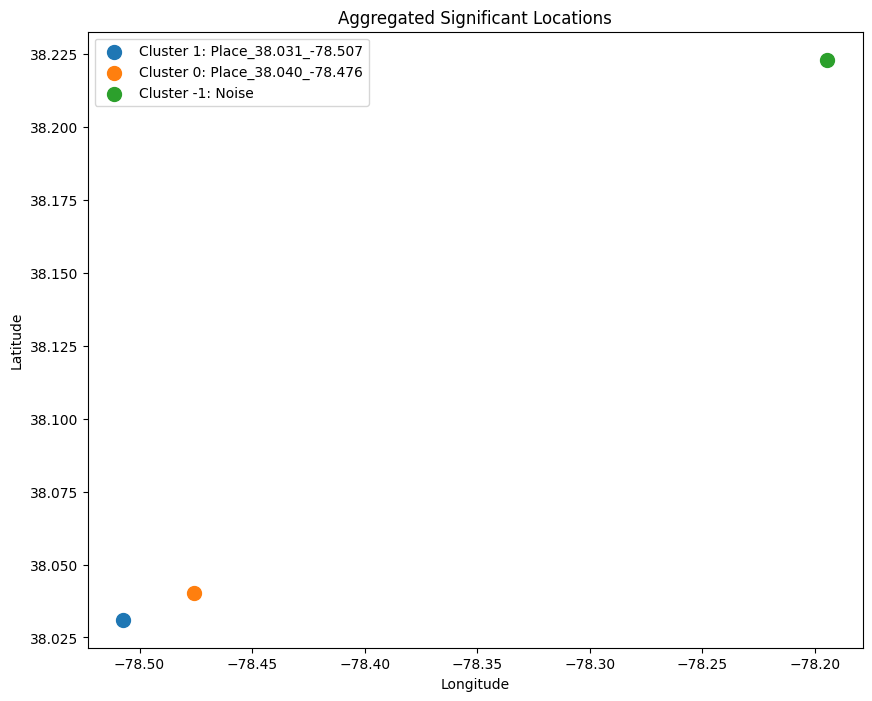

Static map saved as static_map.png
Interactive map saved as interactive_map.html


In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import hdbscan

def parse_location_history(file_path, time_threshold=30):
    """
    Parse the JSON file and extract 'visit' entries with a duration above the threshold.
    Expected location format: 'geo:latitude,longitude'.
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    records = []
    for entry in data:
        if "visit" in entry:
            visit = entry["visit"]
            if "topCandidate" in visit and "placeLocation" in visit["topCandidate"]:
                loc_str = visit["topCandidate"]["placeLocation"]
                if loc_str.startswith("geo:"):
                    try:
                        lat_str, lon_str = loc_str[4:].split(',')
                        lat = float(lat_str)
                        lon = float(lon_str)
                    except Exception:
                        continue
                else:
                    continue
                
                try:
                    start_time = datetime.fromisoformat(entry["startTime"].replace("Z", "+00:00"))
                    end_time = datetime.fromisoformat(entry["endTime"].replace("Z", "+00:00"))
                except Exception:
                    continue
                
                duration = (end_time - start_time).total_seconds() / 60.0  # minutes
                if duration >= time_threshold:
                    records.append({
                        'latitude': lat,
                        'longitude': lon,
                        'start_time': start_time,
                        'end_time': end_time,
                        'duration': duration
                    })
    
    return pd.DataFrame(records)

def cluster_locations(df, min_cluster_size=3, cluster_epsilon=0.0001):
    """
    Cluster the locations using HDBSCAN with the haversine metric.
    """
    coords = df[['latitude', 'longitude']].to_numpy()
    coords_rad = np.radians(coords)
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric='haversine',
        cluster_selection_epsilon=cluster_epsilon
    )
    
    df['cluster'] = clusterer.fit_predict(coords_rad)
    return df, clusterer

def merge_cluster_summary(df):
    """
    Compute and merge cluster statistics into the original dataset.
    """
    summary = df.groupby('cluster').agg(
        visit_count=('duration', 'size'),
        average_duration=('duration', 'mean'),
        center_latitude=('latitude', 'mean'),
        center_longitude=('longitude', 'mean')
    ).reset_index()
    
    return df.merge(summary, on='cluster', how='left')

def query_place_api(lat, lon):
    """ Placeholder function for an API call to fetch place metadata. """
    return f"Place_{lat:.3f}_{lon:.3f}"

def add_cluster_labels(merged_df):
    """ Assign labels to clusters using an API query or placeholder function. """
    label_map = {
        cluster: ("Noise" if cluster == -1 else query_place_api(
            merged_df[merged_df['cluster'] == cluster]['center_latitude'].iloc[0],
            merged_df[merged_df['cluster'] == cluster]['center_longitude'].iloc[0]
        ))
        for cluster in merged_df['cluster'].unique()
    }
    merged_df['label'] = merged_df['cluster'].map(label_map)
    return merged_df

def save_csv(merged_df, output_file='significant_places.csv'):
    """ Save the processed data to a CSV file. """
    merged_df.to_csv(output_file, index=False)
    print(f"Saved detailed significant locations to {output_file}")

def plot_static_map(merged_df):
    """ Generate a static scatter plot of cluster centers. """
    unique_clusters = merged_df.drop_duplicates(subset=['cluster'])
    plt.figure(figsize=(10, 8))
    for _, row in unique_clusters.iterrows():
        plt.scatter(row['center_longitude'], row['center_latitude'], s=100, label=f"Cluster {row['cluster']}: {row['label']}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Aggregated Significant Locations")
    plt.legend()
    plt.savefig("static_map.png")
    plt.show()
    print("Static map saved as static_map.png")

def plot_interactive_map(merged_df):
    """ Generate an interactive map with folium. """
    map_center = [merged_df['latitude'].mean(), merged_df['longitude'].mean()]
    m = folium.Map(location=map_center, zoom_start=12)
    
    unique_clusters = merged_df.drop_duplicates(subset=['cluster'])
    for _, row in unique_clusters.iterrows():
        popup_text = f"Cluster {row['cluster']}: {row['label']}<br>Visits: {row['visit_count']}<br>Avg Duration: {row['average_duration']:.1f} min"
        folium.Marker(
            location=[row['center_latitude'], row['center_longitude']],
            popup=popup_text,
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(m)
    
    heat_data = merged_df[['latitude', 'longitude']].values.tolist()
    HeatMap(heat_data).add_to(m)
    
    m.save("interactive_map.html")
    print("Interactive map saved as interactive_map.html")

if __name__ == "__main__":
    # Parameters
    TIME_THRESHOLD = 30  # minutes
    MIN_CLUSTER_SIZE = 3
    CLUSTER_EPSILON = 0.0001
    
    # Process location history
    df = parse_location_history("location-history.json", time_threshold=TIME_THRESHOLD)
    if df.empty:
        print("No significant stays found.")
    else:
        print(f"Found {len(df)} significant stay points.")
    
    # Clustering
    df, clusterer = cluster_locations(df, min_cluster_size=MIN_CLUSTER_SIZE, cluster_epsilon=CLUSTER_EPSILON)
    
    # Merge cluster statistics
    merged_df = merge_cluster_summary(df)
    
    # Add labels
    merged_df = add_cluster_labels(merged_df)
    
    # Save results
    save_csv(merged_df)
    
    # Generate maps
    plot_static_map(merged_df)
    plot_interactive_map(merged_df)
